In [13]:

import nixio
import os
import scipy.io as spio
import numpy as np

%config InlineBackend.figure_formats = ['retina'] # only for users with a high resolution display
import matplotlib.pyplot as plt
%matplotlib inline


def load_intra_data():
    """
    Returns the time and the voltage vectors stored in the "intra_data.mat" file.

    Returns:
        time, voltage: the vectors containing time and measured voltage.
    """
    data = spio.loadmat(os.path.join("resources", "intra_data.mat"))

    return data["time"][0], data["voltage"][0]


def load_lfp_fake_data():
    """
    Returns the time and the voltage vectors stored in the "lfp_fake_data.mat" file.

    Returns:
        time, voltage: the vectors containing time and measured voltage.
    """
    data = spio.loadmat(os.path.join("resources", "lfp_fake_data.mat"))

    return data["time"][0], data["lfp"]


def get_label(obj):
    """ Returns a string that can be used as an axis label. Constructs the label from DataArray or Dimension objects.

    Args:
        obj (nixio.DataArray or nixio.Dimension): the object of which an axis label should be created.

    Returns:
        string: The label incling unit, if given. Empty string for invalid objects
    """
    label = ""
    if isinstance(obj, (nixio.DataArray, nixio.SampledDimension, nixio.RangeDimension)):
        label = "%s %s" % (obj.label, ("" if obj.unit is None else "[%s]" % obj.unit))
    elif isinstance(obj, (nixio.SetDimension)) and hasattr(obj, "label"):
        label = obj.label

    return label


def threshold_crossings(data, threshold=0.0, flank="rising"):
    """
    Returns the indices of threshold crossings in a given signal.
    :param data: the signal.
    :param threshold: the threshold. Default 0.0.
    :param flank: accepts values {"rising", "falling"} with "rising" being the default.

    :return: the indices of the threshold crossings.
    """
    flanks = ["rising", "falling"]
    if flank.lower() not in flanks:
        flank = flanks[0]
    data = np.squeeze(data)
    if len(data.shape) > 1:
        raise Exception("trace must be 1-D")
    shifted_data = np.hstack((0, data[0:-1]))
    if flank.lower() == "rising":
        crossings = (data > threshold) & (shifted_data <= threshold)
    else:
        crossings = (data < threshold) & (shifted_data >= threshold)
    positions = np.nonzero(crossings)[0]

    return positions


# Solutions for hand-on session 1

## 1) File handling

## 2) Storing regularly sampled data

Text(0, 0.5, 'voltage [mV]')

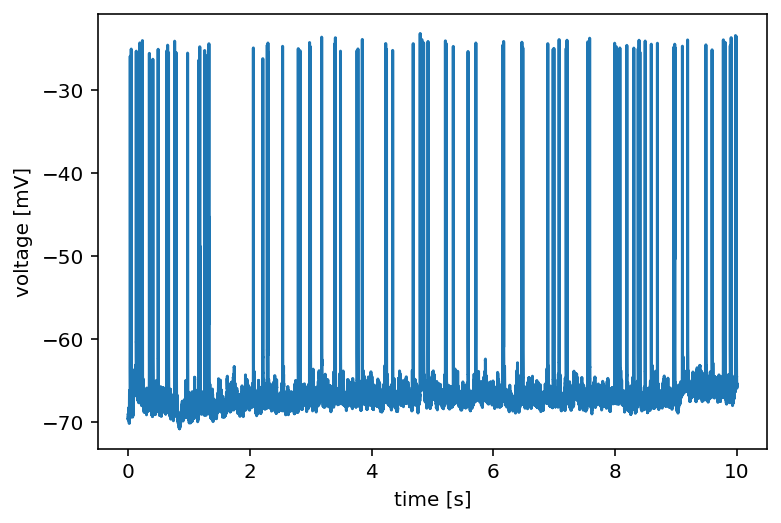

In [14]:
time, voltage = load_intra_data()
sampling_interval = np.mean(np.diff(time))

plt.plot(time, voltage)
plt.xlabel("time [s]")
plt.ylabel("voltage [mV]")


Storing of the data boils down to creating the data array, passing the data and appending a **SampledDimension**.

In [15]:
sampling_interval = np.mean(np.diff(time))

nixfile = nixio.File.open("intracellular_data.nix", nixio.FileMode.Overwrite)
block = nixfile.create_block("session 1", "nix.session")
array = block.create_data_array("intracellular data", "nix.data.sampled", data=voltage, label="voltage", unit="mV")
array.append_sampled_dimension(sampling_interval, label="time", unit="s")

nixfile.close()

## 3) Read data and create a fully labeled plot

In the previous task we used information about the data that came out of the blue, now we use only information that is contained in the file.

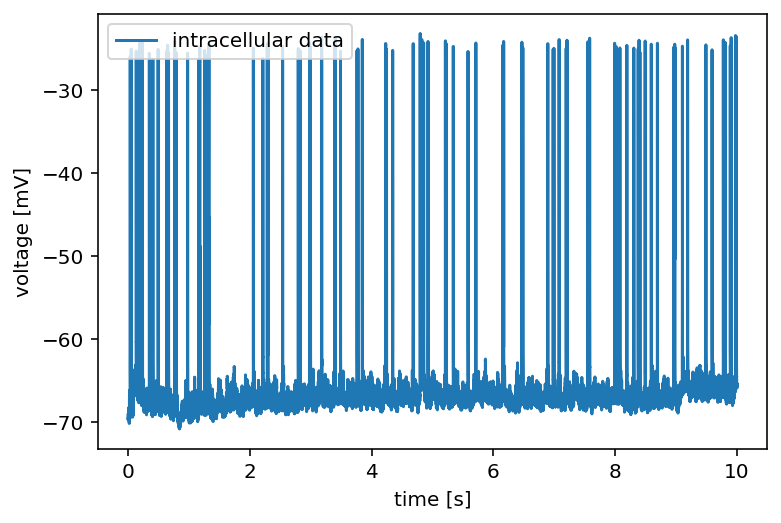

In [16]:
nixfile = nixio.File.open("intracellular_data.nix", nixio.FileMode.ReadOnly)
block = nixfile.blocks["session 1"]
data_array = block.data_arrays["intracellular data"]
data = data_array[:]
dimension = data_array.dimensions[0]
time = dimension.axis(len(data))

plt.plot(time, data, label=data_array.name)
plt.xlabel(get_label(dimension))
plt.ylabel(get_label(data_array))
plt.legend()

nixfile.close()


## 4) Detect and store spike times.

In [17]:
nixfile = nixio.File.open("intracellular_data.nix", nixio.FileMode.ReadWrite)

block = nixfile.blocks["session 1"]
data_array = block.data_arrays["intracellular data"]

# read the data and detect the spikes
intra_data = data_array[:]
time = np.asarray(data_array.dimensions[0].axis(len(intra_data)))  # this is a little annoying, but the axis method returns a tuple
spike_indices = threshold_crossings(intra_data, -30)
spike_times = time[spike_indices]

# store spike times in the file
spikes_array = block.create_data_array("spike times", "nix.irregular_sampled.spike_times", data=spike_times, label="time", unit="s")
spikes_array.append_range_dimension_using_self()

nixfile.close()

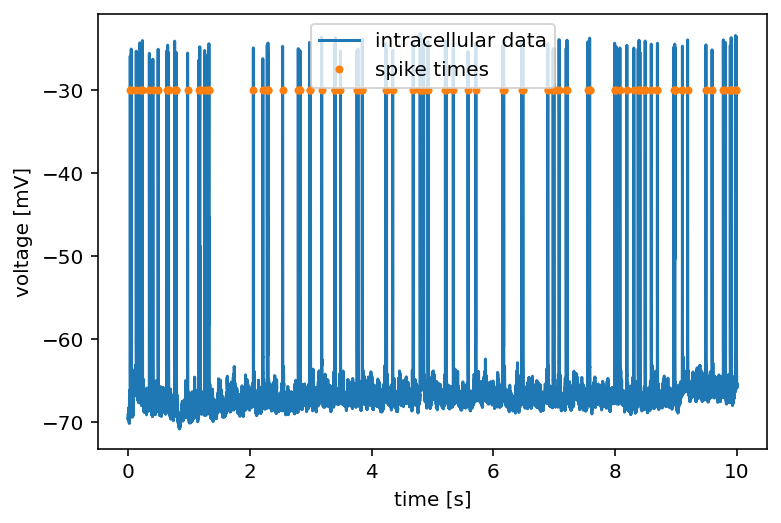

In [18]:
nixfile = nixio.File.open("intracellular_data.nix", nixio.FileMode.ReadOnly)
block = nixfile.blocks["session 1"]
intra_array = block.data_arrays["intracellular data"]
data = intra_array[:]
dimension = intra_array.dimensions[0]
time = dimension.axis(len(data))

spikes_array = block.data_arrays["spike times"]
spike_times = spikes_array[:]

plt.plot(time, data, label=intra_array.name)
plt.plot(spike_times, np.ones(len(spike_times)) * -30, ls="none", marker=".", label=spikes_array.name)
plt.xlabel(get_label(dimension))
plt.ylabel(get_label(intra_array))
plt.legend()

nixfile.close()

## 5) Storing multidimensional data


In [19]:
time, multichannel_data = load_lfp_fake_data()

dt = np.mean(np.diff(time))
number_of_channels = multichannel_data.shape[1]

nixfile = nixio.File.open("lfp_fake.nix", nixio.FileMode.Overwrite)
block = nixfile.create_block("session 1", "nix.session")

multichannel_array = block.create_data_array("lfp", "nix.sampled.set", data=multichannel_data, label="lfp", unit="uV")
multichannel_array.append_sampled_dimension(sampling_interval=dt, unit="s", label="time")
multichannel_array.append_set_dimension(labels=["channel %i" % i for i in range(number_of_channels)])

nixfile.close()


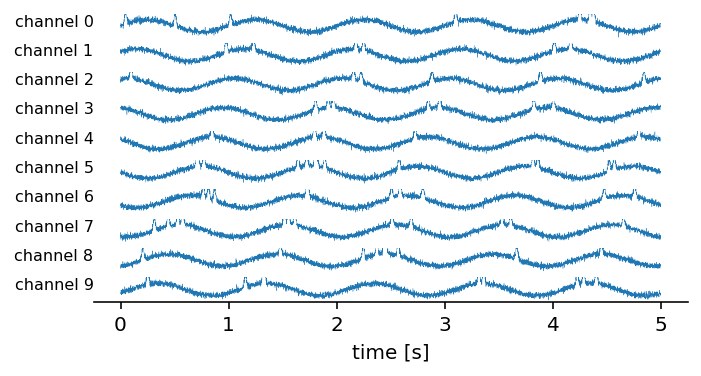

In [8]:
def plot(data_array):
    plot_samples = 5000
    channel_count = data_array.shape[1]

    time = data_array.dimensions[0].axis(plot_samples)
    dt = data_array.dimensions[0].sampling_interval
    labels = data_array.dimensions[1].labels
    data = data_array[:plot_samples, :]

    fig = plt.figure(figsize=(5, 2.5))
    for channel in range(channel_count):
        axis = fig.add_subplot(channel_count, 1, channel + 1)
        axis.plot(time, data[:, channel], label=labels[channel], lw=0.2)
        for sp in axis.spines.keys():
            axis.spines[sp].set_visible(False)
        axis.set_xticks([])
        axis.set_yticks([])
        axis.set_ylim([-2, 2])
        axis.text(0.0, 0.5, labels[channel], rotation=0, fontsize=8, ha="right", transform=axis.transAxes)

    axis.spines["bottom"].set_visible(True)
    axis.set_xticks(np.arange(0, plot_samples * dt + dt, plot_samples / 5 * dt, dtype=int))
    axis.set_xlabel("%s %s" % (data_array.dimensions[0].label, "[%s]" % data_array.dimensions[0].unit if data_array.dimensions[0].unit else ""))
    fig.subplots_adjust(left=0.15, bottom=0.175, top=0.975, right=0.975)
    plt.show()

nixfile = nixio.File.open("lfp_fake.nix", nixio.FileMode.ReadOnly)
block = nixfile.blocks["session 1"]

lfp_array = block.data_arrays["lfp"]
plot(lfp_array)

nixfile.close()